In [1]:
######################################################################################################
import time

# Runtime starting time
start_time = time.time()

import pandas as pd 
import numpy as np
import os 
from datetime import datetime as dt

######################################################################################################

root = r"C:\Users\aleen\Desktop\Master Thesis\Data\amsterdam\listings"
os.chdir(root)
df = pd.read_csv(root + "\listings.csv", low_memory=False)

######################################################################################################

def pandas_display_options(rows, columns, width):
    '''
    This function is suited for EDA. It allows you to display samples of big dataframes in iPython.
    '''
    pd.set_option('display.max_rows', rows)
    pd.set_option('display.max_columns', columns) # So we can display all columns
    pd.set_option('display.width', width)
    
######################################################################################################

def dtype_groups(df):
    '''
    A very elegant way of displaying the features, grouped by their data types.
    '''
    return (df.columns.to_series().groupby(df.dtypes).groups)

######################################################################################################

def amenities_counter(amenities):
    '''
    Counts the number of amenities. I don't think they're that great.
    To run this function, try: df["amenities_counter"] = df.amenities.map(amenities_counter)
    '''
    return len(amenities.split(","))

######################################################################################################

def top_ammenities(df, top =None, plot = False):
    '''
    This function takes apart that horrible looking dictionary and returns for us the x most common/uncommon ammenities.
    It can also plot them if you like.
    '''
    from collections import Counter
    results = Counter()
    df['amenities'].str.strip('{}')\
                   .str.replace('"', '')\
                   .str.lstrip('\"')\
                   .str.rstrip('\"')\
                   .str.split(',')\
                   .apply(results.update)
    
    if plot == True:
        import matplotlib.pyplot as plt
        # create a new dataframe
        sub_df0 = pd.DataFrame(results.most_common(top), columns=['amenity', 'count'])
        # plot the Top 
        sub_df0.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
        plt.xlabel('Count');
        

    return(results.most_common(top))

######################################################################################################

def get_nulls(df):
    '''
    This function prints out the columns which have or do not have null values and the sum of nulls.
    Then, if present, it finally prints out only the names of the columns which are problematic. 
    
    Input: A data frame. 
    
    '''
    columns = df.columns
    
    # Print which columns have nulls or not. 
    print('\033[1m')
    print("Information about which columns have nulls or not:")
    print('\033[0m')
    print(df.isna().any())
    
    # How many nulls in each column?
    print('\033[1m')
    print("How many null values does each variable hold?")
    print('\033[0m')
    print(df.isna().sum())
    
    # List to store result 
    problem_columns = []
    
    # Names of columns with problems. 
    for i in range (0, len(df.isna().sum())):
        if df.isna().sum()[i] == 0:
            problem_columns.append(columns[i])
    if not problem_columns:
        print('\033[1m\nThere are no variables affected by null values.\033[0m')
    else:
        print('\033[1m\nThese are the column names of the variables which present problems:\033[0m')
        print(problem_columns)

######################################################################################################

''' MISCELANEOUS '''

######################################################################################################

def convert_to_euro(amount,currency):
    '''
    This converter uses no API at the moment. Just need to update the currency rate list.
    You input the amount of currency you want to convert and the currency you convert to.
    '''
    rates = [(0.13,"DKK"),(1.20,"GBP"),(1.0,"EUR")]
    
    def getall(my_list, s):
        index = [x for x, y in my_list if y==s] # Very versatile. 
        return (index[0])
    
    rate = getall(rates, currency)
    out = amount * rate
    return (out)

######################################################################################################

def text_word_len(text):
    '''
    Returns the length of a text (in number of words used).
    This could ascribe some quantifiable value to strings.
    '''
    return(len(text.split(" ")))

######################################################################################################

def amenities_list_counter(amenities):
    '''
    Returns the length of an amenities group list.
    '''
    return len(amenities)

######################################################################################################

''' DATA TYPE CONVERSION '''

######################################################################################################

def listings_to_datetime(df, feature):
    df[feature] = pd.to_datetime(df[feature])
    
######################################################################################################

def listings_to_float(df, feature):
    df[feature] = df[feature].astype(float)

######################################################################################################

def price_to_float(df, feature):
    '''
    This function deletes dollar signs from prices and then converts the remaining string to float.
    '''
    df[feature] = df[feature].replace('[\$,]', '', regex=True).astype(float)
    df[feature] = pd.to_numeric(df[feature])

######################################################################################################

def percent_string_to_number(df, feature):
    '''
    Replaces the string % and then converts the number to a percentage between 0 and 1.
    Here, it's host response rate.
    '''
    df[feature] = df[feature].str.replace('%', '').astype(float)
    df[feature] = df[feature] / 100
    
######################################################################################################

def memory_optimization(df, feature):
    '''
    Transforming features to category instead of obsects saves up a lot of physical memory space.
    '''
    df[feature] = df[feature].astype('category')

######################################################################################################

''' NANS, OUTLIERS AND DUPLICATES'''

######################################################################################################

def fill_nans(df,feature,filling="mean"):
    '''
    Fills Nans by replacing them with either median, mean, or a value chosen by the user.
    Default filling value is mean.
    '''
    if filling == "median":
        median = df[feature].median()
        df[feature] = df[feature].fillna(median)
    elif filling == "mean":
        mean = df[feature].mean()
        df[feature] = df[feature].fillna(mean)
    else:
        df[feature].fillna(filling, inplace=True)

######################################################################################################

def remove_outliers(df,feature, bound = "both", method="iqr"):
    '''
    This function removes outliers in a versatile way, according to needs and preferences.
    The method is either Interquartilic Range, Z-Scores or just deleting the dop and bottom 1% values.
    Furthermore, you can specify if you want to remove the lower or upper bound outliers. Or both.
    '''
    if method == "iqr":
        q1 = df[feature].quantile(0.25)
        q3 = df[feature].quantile(0.75)
        iqr = q3-q1
        lower_bound = q1 - (1.5*iqr)
        upper_bound = q3 + (1.5*iqr)
        
        if bound == "both":
            df.drop(df[ (df[feature] > upper_bound) & (df[feature]) < lower_bound].index, axis=0, inplace=True)
        elif bound == "lower":
            df.drop(df[ df[feature] < lower_bound ].index, axis=0, inplace=True)
        elif bound == "upper":
            df.drop(df[ df[feature] > upper_bound ].index, axis=0, inplace=True)
        
    elif method == "zscore":
        from scipy import stats
        df.drop(df[ np.abs(stats.zscore(df[feature]) < 3)], axis=0, inplace=True)
                
    elif method == "1%":
        qhigh = df[feature].quantile(0.99)
        qlow = df[feature].quantile(0.01)
        
        if bound == "both":
            df.drop(df[ (df[feature] > qhigh) & (df[feature] < qlow) ].index, axis=0, inplace=True)
        elif bound == "lower":
            df.drop(df[ df[feature] < qlow ].index, axis=0, inplace=True)
        elif bound == "upper":
            df.drop(df[ df[feature] > qhigh ].index, axis=0, inplace=True)

######################################################################################################

def delete_rows_conditional(df, condition1, threshold1, feature1,
                condition2 = None, threshold2 = None, feature2 = None, 
                logical_operator = None):
    '''
    
    This function deletes rows based on certain features, conditions and thresholds. 
    The features and conditions are not unique and can repeat themselves.
    The logical operator parameter dictates the relationship between the two conditions.
    
    The following parameters can take only the following values:
        - condition = ['greater_than', 'lesser_than', 'equal_to', 'not_equal_to']
        - logical_operator = ['and', 'or']
    
    '''
    ########### 1) ONE CONDITION CASE ##########
    if condition2 == None:
    
        if condition1 == 'greater_than':
            df.drop(df[ (df[feature1] > threshold1) ].index, axis=0, inplace=True)

        elif condition1 == 'lesser_than':
            df.drop(df[ (df[feature1] < threshold1) ].index, axis=0, inplace=True)

        elif condition1 == 'equal_to':
            df.drop(df[ (df[feature1] == threshold1) ].index, axis=0, inplace=True)

        elif condition1 == 'not_equal_to':
            df.drop(df[ (df[feature1] != threshold1) ].index, axis=0, inplace=True)
        
        
    ########### 2) TWO CONDITIONS CASE ##########
    
    #################################################################################################################
    elif condition1 == 'greater_than' and condition2 == 'greater_than' and condition3 == None:
        if logical_operator == 'and':
            df.drop(df[ (df[feature1] > threshold1) and (df[feature2] > threshold2) ].index, axis=0, inplace=True)
        elif logical_operator == 'or':
            df.drop(df[ (df[feature1] > threshold1) | (df[feature2] > threshold2) ].index, axis=0, inplace=True)
            
    elif condition1 == 'greater_than' and condition2 == 'lesser_than' and condition3 == None:
        if logical_operator == 'and':
            df.drop(df[ (df[feature1] > threshold1) and (df[feature2] < threshold2) ].index, axis=0, inplace=True)
        elif logical_operator == 'or':
            df.drop(df[ (df[feature1] > threshold1) | (df[feature2] < threshold2) ].index, axis=0, inplace=True)
            
    elif condition1 == 'lesser_than' and condition2 == 'greater_than' and condition3 == None:
        if logical_operator == 'and':
            df.drop(df[ (df[feature1] < threshold1) and (df[feature2] > threshold2) ].index, axis=0, inplace=True)
        elif logical_operator == 'or':
            df.drop(df[ (df[feature1] < threshold1) | (df[feature2] > threshold2) ].index, axis=0, inplace=True)
            
    elif condition1 == 'lesser_than' and condition2 == 'lesser_than':
        if logical_operator == 'and':
            df.drop(df[ (df[feature1] < threshold1) and (df[feature2] < threshold2) ].index, axis=0, inplace=True)
        elif logical_operator == 'or':
            df.drop(df[ (df[feature1] < threshold1) | (df[feature2] < threshold2) ].index, axis=0, inplace=True)
            
    #################################################################################################################        
            
    elif condition1 == 'equal_to' and condition2 == 'equal_to':
        if logical_operator == 'and':
            df.drop(df[ (df[feature1] == threshold1) and (df[feature2] == threshold2) ].index, axis=0, inplace=True)
        elif logical_operator == 'or':
            df.drop(df[ (df[feature1] == threshold1) | (df[feature2] == threshold2) ].index, axis=0, inplace=True)
            
    elif condition1 == 'not_equal_to' and condition2 == 'not_equal_to':
        
        if logical_operator == 'and':
            df.drop(df[ (df[feature1] != threshold1) and (df[feature2] != threshold2) ].index, axis=0, inplace=True)
        elif logical_operator == 'or':
            df.drop(df[ (df[feature1] != threshold1) | (df[feature2] != threshold2) ].index, axis=0, inplace=True)
            
    elif condition1 == 'equal_to' and condition2 == 'not_equal_to':
        if logical_operator == 'and':
            df.drop(df[ (df[feature1] == threshold1) and (df[feature2] != threshold2) ].index, axis=0, inplace=True)
        elif logical_operator == 'or':
            df.drop(df[ (df[feature1] == threshold1) | (df[feature2] != threshold2) ].index, axis=0, inplace=True)
            
    elif condition1 == 'not_equal_to' and condition2 == 'equal_to':
        if logical_operator == 'and':
            df.drop(df[ (df[feature1] != threshold1) and (df[feature2] == threshold2) ].index, axis=0, inplace=True)
        elif logical_operator == 'or':
            df.drop(df[ (df[feature1] != threshold1) | (df[feature2] == threshold2) ].index, axis=0, inplace=True)
            
    #################################################################################################################
    
    elif condition1 == 'greater_than' and condition2 == 'equal_to':
        if logical_operator == 'and':
            df.drop(df[ (df[feature1] != threshold1) and (df[feature2] == threshold2) ].index, axis=0, inplace=True)
        elif logical_operator == 'or':
            df.drop(df[ (df[feature1] != threshold1) | (df[feature2] == threshold2) ].index, axis=0, inplace=True)
            
    elif condition1 == 'greater_than' and condition2 == 'not_equal_to':
        if logical_operator == 'and':
            df.drop(df[ (df[feature1] > threshold1) and (df[feature2] != threshold2) ].index, axis=0, inplace=True)
        elif logical_operator == 'or':
            df.drop(df[ (df[feature1] > threshold1) | (df[feature2] != threshold2) ].index, axis=0, inplace=True)
        
    elif condition1 == 'equal_to' and condition2 == 'greater_than':
        if logical_operator == 'and':
            df.drop(df[ (df[feature1] == threshold1) and (df[feature2] > threshold2) ].index, axis=0, inplace=True)
        elif logical_operator == 'or':
            df.drop(df[ (df[feature1] == threshold1) | (df[feature2] > threshold2) ].index, axis=0, inplace=True)
        
    elif condition1 == 'not_equal_to' and condition2 == 'greater_than':
        if logical_operator == 'and':
            df.drop(df[ (df[feature1] != threshold1) and (df[feature2] > threshold2) ].index, axis=0, inplace=True)
        elif logical_operator == 'or':
            df.drop(df[ (df[feature1] != threshold1) | (df[feature2] > threshold2) ].index, axis=0, inplace=True)
    
    elif condition1 == 'lesser_than' and condition2 == 'equal_to':
        if logical_operator == 'and':
            df.drop(df[ (df[feature1] < threshold1) and (df[feature2] == threshold2) ].index, axis=0, inplace=True)
        elif logical_operator == 'or':
            df.drop(df[ (df[feature1] < threshold1) | (df[feature2] == threshold2) ].index, axis=0, inplace=True)
        
    elif condition1 == 'lesser_than' and condition2 == 'not_equal_to':
        if logical_operator == 'and':
            df.drop(df[ (df[feature1] < threshold1) and (df[feature2] != threshold2) ].index, axis=0, inplace=True)
        elif logical_operator == 'or':
            df.drop(df[ (df[feature1] < threshold1) | (df[feature2] != threshold2) ].index, axis=0, inplace=True)
        
    elif condition1 == 'equal_to' and condition2 == 'lesser_than':
        if logical_operator == 'and':
            df.drop(df[ (df[feature1] == threshold1) and (df[feature2] < threshold2) ].index, axis=0, inplace=True)
        elif logical_operator == 'or':
            df.drop(df[ (df[feature1] == threshold1) | (df[feature2] < threshold2) ].index, axis=0, inplace=True)
        
    elif condition1 == 'not_equal_to' and condition2 == 'lesser_than':
        if logical_operator == 'and':
            df.drop(df[ (df[feature1] != threshold1) and (df[feature2] < threshold2) ].index, axis=0, inplace=True)
        elif logical_operator == 'or':
            df.drop(df[ (df[feature1] != threshold1) | (df[feature2] < threshold2) ].index, axis=0, inplace=True)
    
    else:
        print("Exception: An error has occured. Please refer to the function's docstring and make sure you specify the parameters correctly.")
        
######################################################################################################

''' FEATURE ENCODING '''

######################################################################################################

def make_dummy(df, feature):
    dummy = pd.get_dummies(df[feature])
    return(dummy)
    # Join the encoded dummy
    #df = df.join(dummy)
    # Drop the initial series
    #df.drop(feature, axis=1,inplace=True)

######################################################################################################

def encode_label(df, feature):
    '''
    Just the Sklearn LabelEncoder but made easier to implement.
    Obs: It's usually preferable to just one-hot encode the data. 
    Label encoding makes the machine think the numbers have some kind of ordinal meaning.
    '''
    from sklearn.preprocessing import LabelEncoder
    labelencoder = LabelEncoder()
    df[feature] = labelencoder.fit_transform(df[feature])

######################################################################################################

def map_feature(df, feature):
    '''
    Just encodes f(false) as 0 and t(true) as 1. 
    '''
    df[feature] = df[feature].map({"f": 0, "t": 1})
    
######################################################################################################

''' NORMALIZATION '''

######################################################################################################

def normalize_price(df,feature,method="standard score",):
    '''
    In statistics, the standard score is the signed fractional number of standard 
    deviations by which the value of an observation or data point is above or below 
    the mean value of what is being observed or measured.
    '''
    # This should get rid of the need to convert currency.
    # And, most importantly, we can now concatenate different listings DF for different cities and even times.
    if method == "standard score":
        df[feature] = (df[feature] - df[feature].mean())/df[feature].std()
        normalized_df=(df-df.mean())/df.std()
        
######################################################################################################

''' FEATURE DELETION '''

######################################################################################################

def drop_or_keep_feature(df, threshold, print_option = False):
    ''' 
    This function deletes features that contain more than x% missing values. 
    Or rather, it returns a tuple containing the names of features to keep and features to drop.
    It also prints them out, if desired. Default is false.
    Threshold example: 30% is 0.3.
    '''
    cols = df.columns.values # Names of features
    lenght = df.shape[0] 
    # Initialize lists
    keep_list = [] 
    drop_list = []
    
    for i in cols:
        x = df[i]
        rate = round(x.isna().sum()/lenght,3)
        if rate < threshold:
            keep_list.append(i)
            if print_option == True:
                print(i,"contain :%",100*rate ,"KEEP.")
        else:
            drop_list.append(i)
            if print_option == True:
                print(i,"contain :%",rate*100 ,"DROP !!!")
            
    return(keep_list, drop_list)

######################################################################################################

''' FEATURE ENGINEERING '''

######################################################################################################

def city_center(city=df["city"].iloc[0]):
    from geopy import Nominatim
    locator = Nominatim(user_agent="aleen_prd")
    location = locator.geocode(city, timeout=5)
    center = (location.latitude, location.longitude)
    return(center)

######################################################################################################

def distance_to_center(acc_lat, acc_lon, center, city_area):
    '''
    Uses an API to calculate the distance in km to the city center of an Airbnb location.
    '''
    from geopy.distance import great_circle
    accommodation = (acc_lat, acc_lon)
    distance = great_circle(center, accommodation).km
    return (distance/city_area)
    
######################################################################################################

def host_age(df, present_year):
    df['host_age'] = (present_year - df['host_since'].dt.year)

######################################################################################################

def assign_property_type_group():
    groups_list = ["apartment","house","secondary","unique","b&b","hotel","ambiguous"]
    groups_lis_list = [apartmentL,houseL,secondaryL,uniqueL,bedbreakfastL,hotelL,ambiguousL]
    
    for g in range(len(groups_list)):
        df.loc[df['property_type'].isin(groups_lis_list[g]), 'property_type_groups'] = groups_list[g]
    
######################################################################################################

def common(row):
    out = []
    for amenity in row['amenities']:
        if amenity in commonL:
            out.append(amenity)
    return(out)
def additional(row):
    out = []
    for amenity in row['amenities']:
        if amenity in additionalL:
            out.append(amenity)
    return(out)
def family(row):
    out = []
    for amenity in row['amenities']:
        if amenity in familyL:
            out.append(amenity)
    return(out)
def logistics(row):
    out = []
    for amenity in row['amenities']:
        if amenity in logisticsL:
            out.append(amenity)
    return(out)
def homesafety(row):
    out = []
    for amenity in row['amenities']:
        if amenity in homesafetyL:
            out.append(amenity)
    return(out)
def location(row):
    out = []
    for amenity in row['amenities']:
        if amenity in locationL:
            out.append(amenity)
    return(out)
def pets(row):
    out = []
    for amenity in row['amenities']:
        if amenity in petsL:
            out.append(amenity)
    return(out)
def access(row):
    out = []
    for amenity in row['amenities']:
        if amenity in accessL:
            out.append(amenity)
    return(out)
def specialneeds(row):
    out = []
    for amenity in row['amenities']:
        if amenity in specialneedsL:
            out.append(amenity)
    return(out)
def spacious(row):
    out = []
    for amenity in row['amenities']:
        if amenity in spaciousL:
            out.append(amenity)
    return(out)
def other(row):
    out = []
    for amenity in row['amenities']:
        if amenity not in all_amenities:
            out.append(amenity)
    return(out)

######################################################################################################

# Setting up optimal display for a dataframe with so many features.
pandas_display_options(3,150,150)

######################################################################################################

commonL = ['Essentials','Kitchen','Air conditioning','Heating','Hair dryer','Hangers','Iron','Washer','Dryer','Hot water',
          'TV','Cable TV','Indoor fireplace','Private entrance','Private living room','Lock on bedroom door','Shampoo',
          'Shower gel','Bed linens','Extra pillows and blankets','Wifi','Ethernet connection','Pocket wifi','Laptop-friendly workspace',
          'Internet','Laptop friendly workspace','Washer / Dryer',' toilet']

additionalL = ['Microwave','Coffee maker','Refrigerator','Dishwasher','Dishes and silverware','Cooking basics','Oven','Stove',
              'Bread maker','Baking sheet','Barbeque utensils','Trash can','Free parking on premises','Free street parking',
              'Paid parking off premises','Paid parking on premises','EV charger','Gym','Pool','Hot tub','Single level home',
              'BBQ grill','Patio or balcony','Garden or backyard','Breakfast','Beach essentials',
              'Handheld shower head','Lockbox','Hot water kettle','Firm mattress']

familyL = ['Baby bath','Baby monitor','Babysitter recommendations','Bathtub','Changing table',"Children's books and toys","Children's dinnerware",
          'Crib','Fireplace guards','Game console','High chair','Outlet covers',"Pack'n Play/travel crib",'Room-darkening shades',
          'Stair gates','Table corner guards','Window guards',
          'Family/kid friendly','Pack ’n Play/travel crib','Children’s books and toys','Children’s dinnerware']

logisticsL = ['Luggage dropoff allowed','Cleaning before checkout','Long term stays allowed',
             'Host greets you','24-hour check-in','Self check-in','Smoking allowed','Suitable for events']

homesafetyL = ['Fire extinguisher','Carbon monoxide alarm','Smoke alarm','First aid kit',
              'Smoke detector','Carbon monoxide detector','Accessible-height bed','Safety card',
              'Accessible-height toilet',]

locationL = ['Beachfront','Lake access','Ski-in/Ski-out','Waterfront']

petsL = ['Pets allowed','Cat(s)','Dog(s)','Pets live on this property']

accessL = ['Buzzer/wireless intercom','Smart lock','No stairs or steps to enter','Elevator','Well-lit path to entrance',
          'Buzzer/wireless intercom','Ground floor access','Flat path to guest entrance','Doorman',
          'Keypad','Wide entrance for guests','Wide hallways','Wide entrance','Wide entryway','Extra space around bed',
            'Wide doorway to guest bathroom','Wide clearance to shower']

specialneedsL = ['Step-free shower','Electric profiling bed','Wheelchair accessible','Disabled parking spot','Building staff']
    
all_amenities = commonL + additionalL + familyL + logisticsL + homesafetyL + locationL + petsL + accessL + specialneedsL 

#####################################################################################################

apartmentL = ['Apartment', 'Condominium', 'Loft']

houseL = ['House', 'Bungalow', 'Cabin', 'Chalet, Cottage', 'Cycladic house (Greece)', 
         'Dammuso (Italy)', 'Dome house', 'Lighthouse', 'Townhouse', 'Trullo (Italy)']

secondaryL = ['Guesthouse', 'Guest suite']

uniqueL = ['Barn', 'Boat', 'Bus', 'Camper/RV', 'Campsite', 'Castle', 'Cave', 'Dome house',
          'Igloo', 'Island', 'Lighthouse', 'Plane', 'Tent', 'Tipi', 'Train', 'Treehouse', 'Windmill', 'Yurt']

bedbreakfastL = ['Bed and breakfast', 'Minsu (Taiwan)','Ryokan (Japan)']

hotelL = ['Boutique hotel', 'Aparthotel', 'Heritage hotel (India)', 'Hostel', 'Hotel',
         'Resort', 'Kezhan (China)']

ambiguousL = ['Casa particular (Cuba)', 'Serviced apartment', 'Pension (South Korea)','Tiny house',"Shepherd's hut (U.K.,France)",
        'Houseboat','Hut','Farm stay','Earth house']

all_listing_types = apartmentL + houseL + secondaryL + uniqueL + bedbreakfastL + hotelL + ambiguousL

#####################################################################################################

#####################################################################################################
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#####################################################################################################
def plotly_text(fig, var1, var2 = None):
    '''
    This function is a helper function.
    It configures the axis and titles for plotly graphs.
    It was neccessary because the process is tedious and has many lines of code.
    '''
    if var2 == None:
        fig.update_layout(
            
        yaxis=go.layout.YAxis(
            title=go.layout.yaxis.Title(
                text=var1,
                font=dict(
                    family="Courier New, monospace",
                    size=18,
                    color="#7f7f7f"
                    )
                )
            )
        )
        
    else: 
        fig.update_layout(
                        
                        xaxis=go.layout.XAxis(
                            title=go.layout.xaxis.Title(
                                text=var2,
                                font=dict(
                                    family="Courier New, monospace",
                                    size=18,
                                    color="#7f7f7f"
                                )
                            )
                        ),
                        yaxis=go.layout.YAxis(
                            title=go.layout.yaxis.Title(
                                text=var1,
                                font=dict(
                                    family="Courier New, monospace",
                                    size=18,
                                    color="#7f7f7f"
                                    )
                                )
                            )
                        )
        
#####################################################################################################
def box_plot(df, style, var1, var2 = None):
    '''
    
    This function is used to print a simple box plot. 
    It uses either Seaborn of Matplotlib as backend.
    The Matplotlib version includes a line depicting the average values.
    The Seaborn version colours the boxes by their categorical variable.
    
    Input: A dataframe, and the column names of the variable of interest.
    
    Output: A box plot type of graph.
            
    Dependencies: Matplotlib and also Seaborn is optional. 
    
    '''
    if var2 == None:
        var = var1
        # Seaborn is optional. It makes the graphs prettier. 
        if style == 'seaborn':
            import seaborn as sns
            sns.set()

            # Building the visualization with Seaborn
            plt.rcParams["figure.figsize"] = (3,6)
            ax = sns.boxplot(y = var, data = df, 
                        notch = True, showfliers = True)

            # Adding custom title and axes labels
            ax.set_title("Boxplot of %s" % var, fontsize =16, fontweight = 'bold').set_position([.5, 1.05])
            plt.show()

        elif style == 'matplotlib':
            # Building the plot with matplotlib
            plt.rcParams["figure.figsize"] = (3,6)
            df.boxplot(var, 
                       notch = True, 
                       patch_artist = False, 
                       showmeans = True, 
                       meanline = True)

            # Adding custom title and axes labels
            plt.title("Boxplot of %s" % (var), fontsize =16, fontweight = 'bold').set_position([.5, 1.05])
            plt.suptitle("") # No default suptitle 
            plt.show()

        elif style == 'plotly':
            fig = px.box(df, y = var, notched = True)

            fig.update_layout(
                title=go.layout.Title(
                text="Boxplot of %s" % (var),
                xref="paper",
                #size=16,
                x=0))

            plotly_text(fig = fig, var1 = var)
            fig.show()

        else:
            print("Input Error: Please check that the plotting style is either 'matplotlib', 'seaborn' or 'plotly' and retry.")
        
    else:
        if style == 'seaborn':
            import seaborn as sns
            # Building the visualization with Seaborn
            plt.rcParams["figure.figsize"] = (9,6)
            ax = sns.boxplot(y = var1, x = var2, data = df, 
                        hue = var2, saturation = 0.75,
                        notch = True, showfliers = True)

            # Adding custom title and axes labels
            ax.set_title("Boxplot of %s grouped by %s" % (var1, var2), fontsize =16, fontweight = 'bold').set_position([.5, 1.05])
            ax.set_xlabel(var2, fontsize = 13)
            ax.set_ylabel(var1, fontsize = 13)

            # Adding a legend
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
        elif style == 'matplotlib':
            # Building the plot with matplotlib
            plt.rcParams["figure.figsize"] = (9,6)
            df.boxplot(column = var1, by = var2, 
                           notch = True, 
                           patch_artist = False, 
                           showmeans = True, 
                           meanline = True)

            # Adding custom title and axes labels
            plt.title("Boxplot of %s grouped by %s" % (var1, var2), fontsize =16, fontweight = 'bold').set_position([.5, 1.05])
            plt.suptitle("") # No default suptitle 
            plt.xlabel(var2, fontsize = 13)
            plt.ylabel(var1, fontsize = 13)
            plt.show()

        elif style == 'plotly':
            fig = px.box(df, x = var2, y = var1, notched = True, color=var2)

            fig.update_layout(
                title=go.layout.Title(
                text="Boxplot of %s grouped by %s" % (var1, var2),
                xref="paper",
                #size=16,
                x=0.5))

            plotly_text(fig = fig, var1 = var1, var2 = var2)
            fig.show()
        
        else:
            print("Input Error: Please check that the plotting style is either 'matplotlib', 'seaborn' or 'plotly' and retry.")
    
#####################################################################################################
def violin_plot(df, style, var1, var2, hue=None, split=False):
    '''
    This function is used to print violin plots. 
    Additional arguments in the function input permit the user to specify different preferences.
    
    Input: A dataframe, and the column names of the variables of interest.
    
    Output: A data visualization representing the box plots of the first variable, 
            grouped according to variable 2, which is a categorical variable. 
            
    Dependencies: Matplotlib and Seaborn. 
    
    '''
    
    if style == 'seaborn':  
        # Building the visualization with Seaborn
        plt.rcParams["figure.figsize"] = (9,6)
        if hue==None and split==False:
            ax = sns.violinplot( x=df[var2], y=df[var1], saturation=0.75)
        elif hue==None and split==True:
            ax = sns.violinplot( x=df[var2], y=df[var1], saturation=0.75, split=split)
        elif hue !=None and split==False:
            ax = sns.violinplot( x=df[var2], y=df[var1], hue=df[hue], saturation=0.75, split=split)
        elif hue !=None and split==True:
            ax = sns.violinplot( x=df[var2], y=df[var1], hue=df[hue], saturation=0.75, split=split)

        # Adding custom title and axes labels
        if hue==None:
            ax.set_title("Violin Plot of %s grouped by %s" % (var1, var2), fontsize =16, fontweight = 'bold').set_position([.5, 1.05])
        else:
            ax.set_title("Violin Plot of %s grouped by %s and coloured by %s" % (var1, var2, hue), fontsize =16, fontweight = 'bold').set_position([.5, 1.05])
        ax.set_xlabel(var2, fontsize = 13)
        ax.set_ylabel(var1, fontsize = 13)

        # Adding a legend
        if hue != None and split != False:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            
    elif style == 'plotly':
        if split == False:
            if hue == None:
                fig = px.violin(df, y=var1, x=var2, box = True, color = var2)
            else:
                fig = px.violin(df, y=var1, x=var2, box = True, color = hue)
        
            fig.update_layout(
                title=go.layout.Title(
                text="Violin Plot of %s grouped by %s" % (var1, var2),
                xref="paper",
                #size=16,
                x=0.5))

            plotly_text(fig = fig, var1 = var1, var2 = var2)

            fig.show()
            
        else:
            print("Input Error: This function cannot display a split violin plot with plotly. Please try the seaborn version.")
            

        
    else: 
        print("Input Error: Please check that the plotting style is either 'seaborn' or 'plotly' and retry.")
        
#####################################################################################################
def histogram_plot(df, style, var, bins = None, hue = None):
    '''
    This function builds histograms in Seaborn.
    It can build a histogram for one variable or even two. 
    This makes it easier to inspect relationships. 
    '''
    if style == 'matplotlib':
        # the histogram of the data
        n, bins, patches = plt.hist(df[var], bins=bins, density=True, facecolor='g', alpha=0.75)

        #plt.xlabel('Smarts')
        #plt.ylabel('Probability')
        plt.title('Histogram of %s' % var, fontsize =16, fontweight = 'bold').set_position([.5, 1.05])
        #plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
        #plt.xlim(40, 160)
        #plt.ylim(0, 0.03)
        plt.grid(True)
        plt.show()
        
    elif style == 'seaborn':
        ax = sns.distplot(df[var])
        ax.set_title("Histogram of %s" % var, fontsize =16, fontweight = 'bold').set_position([.5, 1.05])
        
    elif style == 'plotly': 
        fig = px.histogram(df, x=var, nbins=bins, color=hue)
        
        fig.update_layout(
                title=go.layout.Title(
                text="Histogram of %s" % var,
                xref="paper",
                #size=16,
                x=0.5))

        #plotly_text(fig = fig, var1 = var1, var2 = var2)
        
        fig.show()
        
    else: 
        print("Input Error: Please check that the plotting style is either 'matplotlib', seaborn' or 'plotly' and retry.")
        
#####################################################################################################
def scatter_plotly(df, var1, var2, color_var = None, size_var = None, hover_data = []):
    
    import plotly.express as px
    fig = px.scatter(df, x=var1, y=var2, color = color_var, size = size_var, hover_data = hover_data)
    fig.show()
    
#####################################################################################################
def scatter_plot(df, var1, var2, seaborn = True):
    '''
    This function is used to print a scatter plot. 
    It uses either Seaborn of Matplotlib as backend.
    
    Input: A dataframe, and the column names of the variables of interest. 
            
    Dependencies: Matplotlib and also Seaborn is optional. 
    
    '''
    
    # Importing neccesary modules. 
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    # Seaborn is optional. It makes the graphs prettier. 
    if seaborn == True:
        import seaborn as sns
        sns.set()
        
        # Building a scatterplot with seaborn 
        plt.rcParams["figure.figsize"] = (9,6)
        ax = sns.scatterplot(df[var1], df[var2])
        
        # Adding custom title and axes labels
        ax.set_title("Scatter Plot of %s and %s" % (var1, var2), fontsize =16, fontweight = 'bold').set_position([.5, 1.05])
        ax.set_xlabel(var2, fontsize = 13)
        ax.set_ylabel(var1, fontsize = 13)
        
        # Adding a legend
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
    else:
        plt.rcParams["figure.figsize"] = (9,6)
        plt.scatter(df[var1], df[var2])

#####################################################################################################
def pie_plot(labels = [], values = [], title = None):
    '''
    This function creates an interactive pie plot using Plotly.
    Title is optional. 
    
    Input example:
        - labels = ['Oxygen','Hydrogen','Carbon_Dioxide','Nitrogen']
        - values = [4500, 2500, 1053, 500]
    '''
    
    # Use `hole` to create a donut-like pie chart
    fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
    
    fig.update_layout(
                title=go.layout.Title(
                text=title,
                xref="paper",
                #size=16,
                x=0.5))
    
    fig.show()
    
#####################################################################################################
def donut_plot(labels = [], values = [], title=None, hole=.3):
    '''
    This function creates an interactive donut plot using Plotly.
    Title is optional. 
    Hole describes the amplitude of the donut hole.
    
    Input example:
        - labels = ['Oxygen','Hydrogen','Carbon_Dioxide','Nitrogen']
        - values = [4500, 2500, 1053, 500]
    '''
    
    # Use `hole` to create a donut-like pie chart
    fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=hole)])
    
    fig.update_layout(
                title=go.layout.Title(
                text=title,
                xref="paper",
                #size=16,
                x=0.5))
    
    fig.show()
    
#####################################################################################################
def bar_plot(df, style, var1, var2 = None, hue = None, barmode = None):
    '''
    This function creates bar plots using either Seaborn or Plotly.
    The barmode can be 'group', 
    '''
    if style == 'seaborn':
        # Building the visualization with Seaborn
        plt.rcParams["figure.figsize"] = (9,6)
        if var2 == None:
            # Printing the frequencies 
            #print(str(df[var1].value_counts(normalize=True)*100))

            # Building the chart 
            ax = sns.countplot(x=var1, data=df, hue=hue)

            #for p in ax.patches:
               # ax.annotate(format(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),
                #            ha='center',va='center',xytext=(0,10),textcoords='offset points',color='black',fontsize=12)

            # Adding custom title and axes labels
            #ax.fig.suptitle("Bar Plot of %s" % var1, fontsize =16, fontweight = 'bold').set_position([.5, 1.05])
            ax.set_title("Bar Plot of %s" % var1, fontsize =16, fontweight = 'bold').set_position([.5, 1.05])
            #ax.set_ylabel("Number of occurences", fontsize = 13)

            # Show plot
            plt.show()
            
        else:
            # Building the chart 
            ax = sns.catplot(x=var1, y=var2, data=df, hue=hue, kind='bar')

            # Adding custom title and axes labels
            #ax.fig.suptitle("Bar Plot of %s" % var1, fontsize =16, fontweight = 'bold').set_position([.5, 1.05])
            ax.set_title("Bar Plot of %s" % var1, fontsize =16, fontweight = 'bold').set_position([.5, 1.05])
            #ax.set_ylabel("Number of occurences", fontsize = 13)

            # Show plot
            plt.show()
            
        
    elif style == 'plotly':
        if hue == None:
            fig = px.bar(data_frame= df, x = var1, y = var2, color = var1)
        else:
            fig = px.bar(data_frame= df, x = var1, y = var2, color = hue)
        
        fig.update_layout(
                title=go.layout.Title(
                text="Bar Plot of %s" % (var1),
                xref="paper",
                #size=16,
                x=0.5))

        plotly_text(fig = fig, var1 = var2, var2 = var1)
        
        # Change the bar mode
        if barmode != None:
            fig.update_layout(barmode=barmode)
        
        # Here we modify the tickangle of the xaxis, resulting in rotated labels.
        fig.update_layout(xaxis_tickangle=-45)
        
        fig.show()
        
    else:
        print("Input Error: Please check that the plotting style is either 'seaborn' or 'plotly' and retry.")

#####################################################################################################
def scatter_matrix(df, style, figsize = None):
    '''
    This function outputs a scatter matrix of the numerical values.
    
    Input: A data frame. 
    
    Dependencies: Uses Pandas. 
    
    '''
    if style == 'matplotlib':
        # Importing libraries
        from pandas.plotting import scatter_matrix

        # Building scatter matrix 
        sm = scatter_matrix(df, figsize=figsize, alpha=0.8)

        # Customizing x and y axis. 
        [s.xaxis.label.set_rotation(45) for s in sm.reshape(-1)]
        [s.yaxis.label.set_rotation(0) for s in sm.reshape(-1)]
        [s.get_yaxis().set_label_coords(-0.3,0.5) for s in sm.reshape(-1)]

        #Hide all ticks
        [s.set_xticks(()) for s in sm.reshape(-1)]
        [s.set_yticks(()) for s in sm.reshape(-1)]

        # Title 
        plt.suptitle("Scatter Matrix (Pandas)", fontsize =16, fontweight = 'bold')

        plt.show()
        
    elif style == 'seaborn':
        # view the relationships between variables; color code by wine quality
        plt.rcParams["figure.figsize"] = figsize
        ax = sns.pairplot(df, hue='gender')

#####################################################################################################
def pearson_matrix(df, figsize=None):
    '''
    This function creates a pretty Pearson's Correlation Matrix.
    
    Input: A data frame; A tuple representing the figure size.
    
    Dependencies: Matplotlib and Seaborn.  
    
    '''
    
    # Importing modules.
    import matplotlib.pyplot as plt 
    import seaborn as sns
    %matplotlib inline
    sns.set()
    
    # Figuresize 
    f,ax = plt.subplots(figsize=figsize)
    
    # Custom title 
    plt.title("Pearson's Correlation Matrix", fontsize=20, fontweight='bold')
    
    # Building the actual matrix. 
    g = sns.heatmap(df.corr(), annot=True, linewidths=.25, fmt= '.1f', ax=ax, vmax=1.0, cbar_kws={"shrink": .75}, cmap="RdYlGn")
    f.tight_layout()
    
    g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    g.set_yticklabels(g.get_yticklabels(), rotation=360, horizontalalignment='right')

#####################################################################################################
#####################################################################################################

df["amenities"] = df["amenities"].apply(lambda x: x.replace('"', ''))
df["amenities"] = df["amenities"].apply(lambda x: x[1:-1].replace("\'", "").split(","))

#####################################################################################################

df['amenities_common'] = df.apply(common, axis=1)
df['amenities_additional'] = df.apply(additional, axis=1)
df['amenities_family'] = df.apply(family, axis=1)
df['amenities_logistics'] = df.apply(logistics, axis=1)
df['amenities_safety'] = df.apply(homesafety, axis=1)
df['amenities_location'] = df.apply(location, axis=1)
df['amenities_pets'] = df.apply(pets, axis=1)
df['amenities_access'] = df.apply(access, axis=1)
df['amenities_special_needs'] = df.apply(specialneeds, axis=1)
df['amenities_other'] = df.apply(other, axis=1)

#####################################################################################################

df['amenities_common'] = df['amenities_common'].map(amenities_list_counter)
df['amenities_additional'] = df['amenities_additional'].map(amenities_list_counter)
df['amenities_family'] = df['amenities_family'].map(amenities_list_counter)
df['amenities_logistics'] = df['amenities_logistics'].map(amenities_list_counter)
df['amenities_safety'] = df['amenities_safety'].map(amenities_list_counter)
df['amenities_location'] = df['amenities_location'].map(amenities_list_counter)
df['amenities_pets'] = df['amenities_pets'].map(amenities_list_counter)
df['amenities_access'] = df['amenities_access'].map(amenities_list_counter)
df['amenities_special_needs'] = df['amenities_special_needs'].map(amenities_list_counter)
print("Amenities done.")
#####################################################################################################

assign_property_type_group()
fill_nans(df,"property_type_groups","other")
dummy = make_dummy(df,"property_type_groups")
df = df.join(dummy)
print("Property type done.")
#####################################################################################################

center = city_center()
city_area = 219.32
df['distance_to_center'] = df.apply(lambda x: distance_to_center(x.latitude, x.longitude, center, city_area), axis=1)
print("Distance done.")

#####################################################################################################
######################################################################################################

to_datetime_list = ['host_since'] # "last_scraped"
for f in to_datetime_list:
    listings_to_datetime(df, f)

price_to_num_list = ['price','security_deposit','cleaning_fee','extra_people','weekly_price','monthly_price']
for f in price_to_num_list:
    price_to_float(df,f)
    
percent_string_to_number(df, 'host_response_rate')

print("Dates, percentages and prices done.")
#####################################################################################################

host_age(df,2020)
print("Host age done.")
#####################################################################################################

text_features_list = ['name','summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes',
                        'transit', 'access', 'interaction', 'house_rules', 'host_about']

for f in text_features_list:
    fill_nans(df,f,"")
    
for f in text_features_list:
    df[f] = df[f].str.split().str.len()
print("Text length done.")

#####################################################################################################
#####################################################################################################

filling = [0.0, 1.0, "f", "t",'no_response',"no bed", "no bathroom","median", "mean"]

# Filling NaN with zeros
fillna_zeros_features_list = ["price",'weekly_price','monthly_price',"extra_people","cleaning_fee",
                              "security_deposit","bathrooms","bedrooms","beds",
                              "review_scores_rating","review_scores_accuracy"]
for f in fillna_zeros_features_list:
    fill_nans(df,f,filling[0])

# Filling NaN with f
fillna_features_list = ["host_is_superhost","instant_bookable","is_business_travel_ready", "host_identity_verified",
                        "require_guest_profile_picture","require_guest_phone_verification"]
for f in fillna_features_list:
    fill_nans(df,f,filling[2])
    
# Filling NaN with "no response"
    fill_nans(df,"host_response_time",filling[4])
    
# Filling NaN with "no bed"
fill_nans(df,"bed_type",filling[5])
    
# Filling NaN with mean
fill_nans(df,'price',filling[8])
print("Filling NaNs done.")

fill_nans(df,'host_age',0)
fill_nans(df,'reviews_per_month',0)
fill_nans(df,'host_total_listings_count',1)
fill_nans(df,'host_response_rate',0)

#####################################################################################################
#####################################################################################################

features_with_outliers_list_0 = ["price"]
for f in features_with_outliers_list_0:
    remove_outliers(df, f, bound = "upper", method = "iqr")
    
features_with_outliers_list_1 = ["cleaning_fee","security_deposit","extra_people",
                                 "accommodates","bathrooms","bedrooms","beds",
                                 "host_total_listings_count"]
for f in features_with_outliers_list_1:
    remove_outliers(df, f, bound = "upper", method = "iqr")

delete_rows_conditional(df, feature1='maximum_nights', condition1='greater_than', threshold1=1125)
delete_rows_conditional(df, feature1='accommodates', condition1='equal_to', threshold1=0)
delete_rows_conditional(df, feature1='price', condition1='equal_to', threshold1=0)
print("Outliers statistically removed done.")
#####################################################################################################

label_encoding_list = ["host_identity_verified","host_has_profile_pic","instant_bookable",
                      "host_is_superhost","is_business_travel_ready",
                       "require_guest_profile_picture","require_guest_phone_verification"]
for f in label_encoding_list:
    map_feature(df,f)
print("Labels encoded done.") 
#####################################################################################################

dummy_feature_list = ["host_response_time","cancellation_policy",
                     "room_type","bed_type"] 
# "host_verifications"
for f in dummy_feature_list:
    dumm = make_dummy(df,f)
    df = pd.concat([df,dumm], axis=1)
print("Makind dummies done.")
#####################################################################################################
#
drop_list = ['thumbnail_url',
 'medium_url',
 'xl_picture_url',
 'host_name',
 'host_since',
 'host_location',
 'host_acceptance_rate',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_has_profile_pic',
 'neighbourhood',
 'neighbourhood_group_cleansed',
 'state',
 'zipcode',
 'market',
 'square_feet',
 'first_review',
 'last_review',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'license',
 'jurisdiction_names']
#####################################################################################################

df.drop(drop_list, axis=1,inplace=True)
df.drop(['amenities','amenities_other'], axis=1,inplace=True)
df.drop(["property_type","property_type_groups"], axis=1,inplace=True)

additional_drop_list = ["listing_url","scrape_id","last_scraped","name","picture_url","host_id","host_url",
                       "host_verifications","street","neighbourhood_cleansed","city","smart_location","country_code",
                       "country","latitude","longitude","is_location_exact","room_type","bed_type",
                       "minimum_minimum_nights","maximum_minimum_nights","minimum_maximum_nights",
                        "maximum_maximum_nights","minimum_nights_avg_ntm","maximum_nights_avg_ntm","calendar_updated","calendar_last_scraped",
                        "has_availability","availability_30","availability_60","availability_90","availability_365",
                        "number_of_reviews_ltm","requires_license",
                        "host_identity_verified","experiences_offered",
                        "host_response_time","cancellation_policy","id","review_scores_accuracy"
                       ]
df.drop(additional_drop_list, axis=1,inplace=True)
print("Dropped some extra features.")
#####################################################################################################

#normalization_list = ['price','security_deposit','cleaning_fee','extra_people','weekly_price','monthly_price']
#for n in normalization_list:
    #normalize_price(df,n)
#print("Normalization done.")

# Runtime ending time
end_time = time.time()

print("Finished in: ", end_time - start_time)

Amenities done.
Property type done.
Distance done.
Dates, percentages and prices done.
Host age done.
Text length done.
Filling NaNs done.
Outliers statistically removed done.
Labels encoded done.
Makind dummies done.
Dropped some extra features.
Finished in:  19.890088319778442


In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df)
scaled = scaler.transform(df)

C:\Users\aleen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.

C:\Users\aleen\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.



In [12]:
df.columns.values

array(['summary', 'space', 'description', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'host_about', 'host_response_rate', 'host_is_superhost',
       'host_total_listings_count', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'price', 'weekly_price', 'monthly_price',
       'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'instant_bookable',
       'is_business_travel_ready', 'require_guest_profile_picture',
       'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'amenities_common', 'amenities_additional', 'amenities_family',
       'amenities_logistics', 'amenities_safety', 'amenities_locatio

In [13]:
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=df.columns.values)

C:\Users\aleen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.

C:\Users\aleen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning:

Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.



In [14]:
scaled_df.head()

,summary,space,description,neighborhood_overview,notes,transit,access,interaction,house_rules,host_about,host_response_rate,host_is_superhost,host_total_listings_count,accommodates,bathrooms,bedrooms,beds,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,amenities_common,amenities_additional,amenities_family,amenities_logistics,amenities_safety,amenities_location,amenities_pets,amenities_access,amenities_special_needs,ambiguous,apartment,b&b,hotel,house,other,secondary,unique,distance_to_center,host_age,a few days or more,no_response,within a day,within a few hours,within an hour,flexible,moderate,strict_14_with_grace_period,super_strict_30,super_strict_60,Entire home/apt,Hotel room,Private room,Shared room,Airbed,Couch,Futon,Pull-out Sofa,Real Bed
0,-0.551116,1.869914,0.374880,-0.779052,0.027211,-0.377922,-0.355817,0.157395,-0.202958,0.438051,1.293905,2.735968,0.266585,-0.587149,0.079848,-0.315764,-0.594518,0.473376,2.904647,4.047989,-0.726736,-1.352247,-0.483415,-0.521800,-0.086348,0.203028,3.892694,0.482368,1.905041,0.0,-0.091661,-0.0976,-0.097629,-1.924789,1.603130,-0.047821,1.257877,0.246826,-0.546195,-0.469272,1.55083,0.752958,4.088596,-0.316546,0.234022,-0.25335,9.056305,-2.653367,-0.119821,-0.02835,-0.278278,-0.053091,-0.10171,-0.112268,-0.770020,2.406734,-0.138313,-1.181223,-0.344889,-0.349608,2.109425,-0.621536,-0.809548,1.441368,-0.020042,-0.01002,-2.191342,-0.063494,2.241199,-0.048105,-0.026517,-0.014171,-0.043714,-0.081041,0.097074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,-2.205320,1.852494,0.446766,-0.905410,5.414043,0.154178,-0.255643,-0.832047,0.652410,1.927171,1.293905,-0.365501,0.266585,0.540077,0.079848,1.343327,0.986948,0.181987,2.541874,3.532851,1.050669,-1.352247,1.114388,1.290597,-0.086348,-1.025497,3.385121,0.387930,-0.524923,0.0,-0.091661,-0.0976,-0.097629,0.341194,-0.366334,-0.047821,0.794558,0.561020,-0.792158,0.830030,1.55083,1.482341,-0.207427,-0.316546,-0.403476,-0.25335,-0.110420,0.376880,-0.119821,-0.02835,-0.278278,-0.053091,-0.10171,-0.112268,-0.875418,2.406734,-0.138313,-1.181223,-0.344889,2.860344,-0.474063,1.608918,-0.809548,-0.693785,-0.020042,-0.01002,0.456341,-0.063494,-0.446190,-0.048105,-0.026517,-0.014171,-0.043714,-0.081041,0.097074


In [ ]:
histogram_plot(scaled_df,"")

KeyboardInterrupt: 

## Further feature selection

### 1) Pearson's correlation Matrix with Heatmap

In [43]:
cor = df.corr()
#Correlation with output variable
cor_target = abs(cor["price"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4]
relevant_features

accommodates    0.410527
price           1.000000
Name: price, dtype: float64

In [44]:
pearson_drop_list = ["is_business_travel_ready","Pull-out Sofa","Futon",
                    "calculated_host_listings_count_shared_rooms","calculated_host_listings_count_entire_homes",
                    "calculated_host_listings_count_shared_rooms","calculated_host_listings_count_private_rooms",
                    "require_guest_phone_verification","beds","Private room",
                    "house","Hotel room","flexible","moderate","host_response_rate","no_response",
                    "reviews_per_month","amenities_common"]
df.drop(pearson_drop_list,inplace=True,axis=1)

Finished in:  4.677429437637329


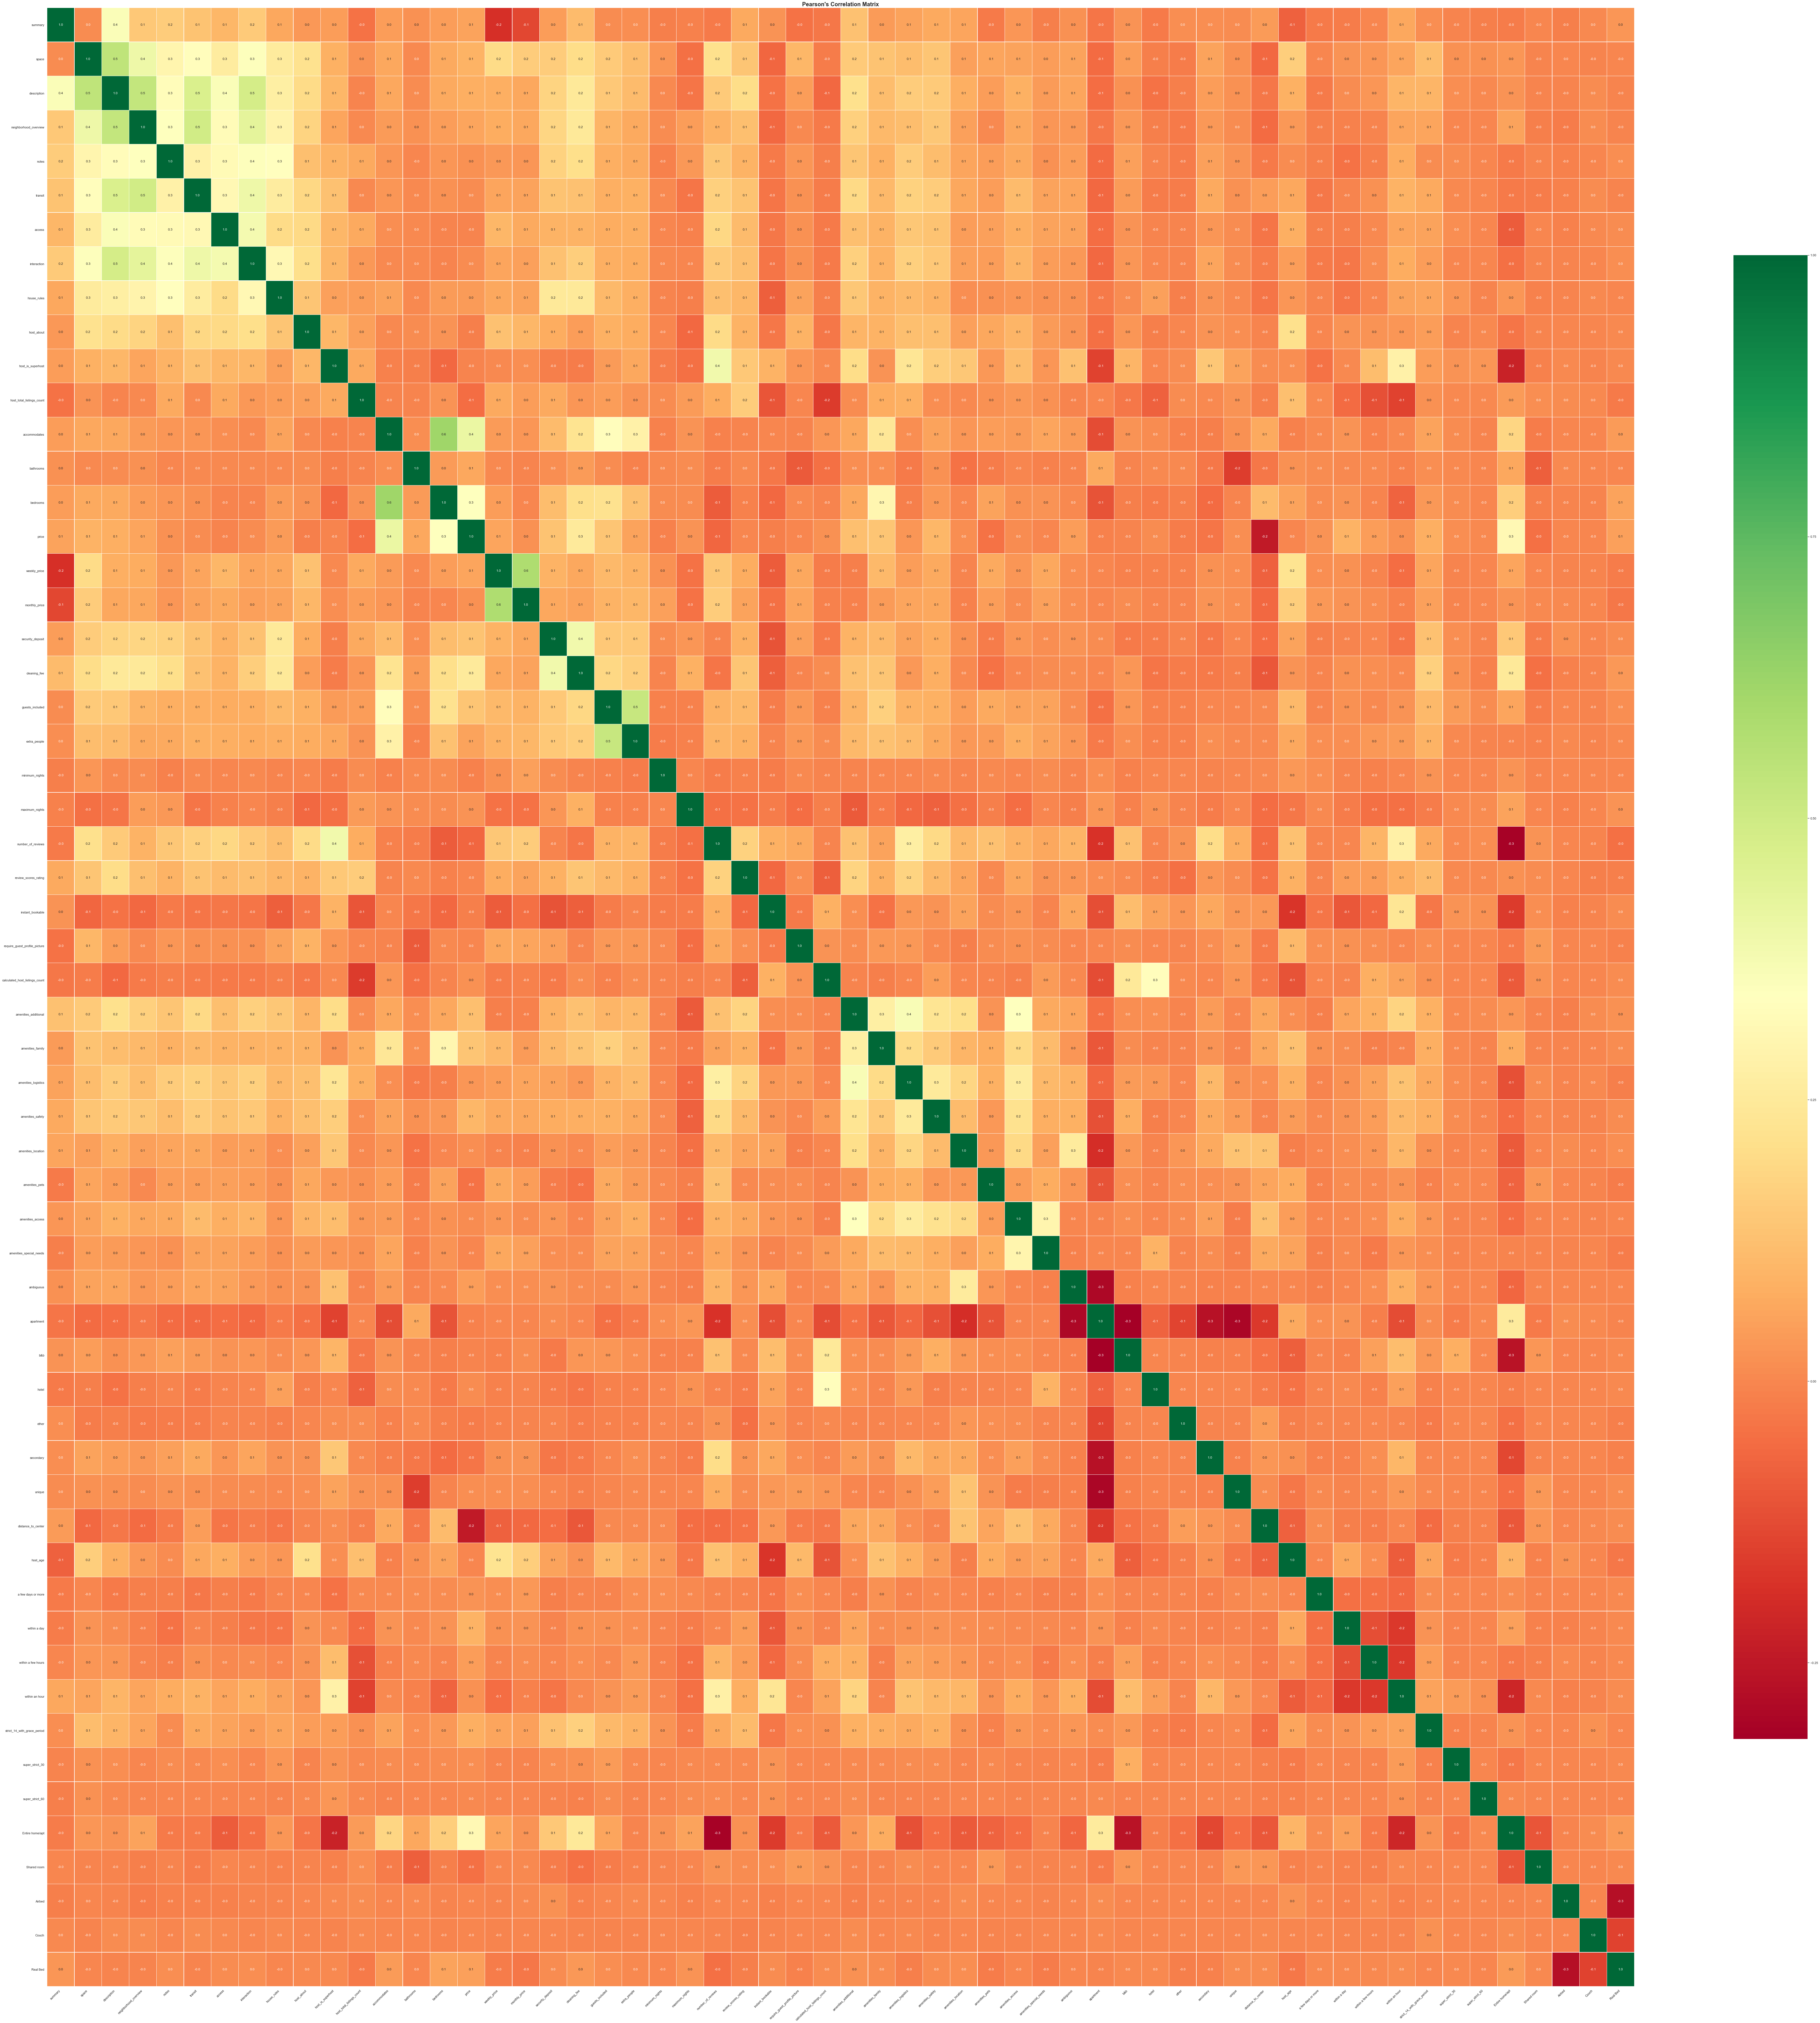

In [36]:
start_time = time.time()
pearson_matrix(df, (100,100))
# Runtime ending time
end_time = time.time()
print("Finished in: ", end_time - start_time)

### 2) Univariate Selection

In [45]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

In [64]:
# Split data into independent variable and dependent variable
X = df.drop("price",axis=1)  #independent columns
y = df["price"]  #target column i.e price range

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)

# Make fit into a DF
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns

In [68]:
l = list(featureScores.sort_values(by='Score',ascending=False).values)
l

[array(['monthly_price', 718406.1295121497], dtype=object),
 array(['weekly_price', 225606.9331501298], dtype=object),
 array(['maximum_nights', 136102.60167889224], dtype=object),
 array(['security_deposit', 101860.43594518118], dtype=object),
 array(['number_of_reviews', 54904.877000145614], dtype=object),
 array(['house_rules', 34848.534310181385], dtype=object),
 array(['space', 29423.947094731153], dtype=object),
 array(['host_about', 21405.07906481097], dtype=object),
 array(['neighborhood_overview', 20723.931608657895], dtype=object),
 array(['notes', 18562.290776949267], dtype=object),
 array(['cleaning_fee', 16969.499508960325], dtype=object),
 array(['transit', 13421.280400251697], dtype=object),
 array(['access', 11909.065025450795], dtype=object),
 array(['description', 9434.087209347437], dtype=object),
 array(['extra_people', 7919.13987201139], dtype=object),
 array(['interaction', 6581.909270817158], dtype=object),
 array(['minimum_nights', 5769.961967992948], dtype=obje

In [74]:
df.shape

(9962, 58)

### 3) Feature Importance feature of Tree Algorithms

In [124]:
# create training and testing vars
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7969, 57) (7969,)
(1993, 57) (1993,)


C:\Users\aleen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



[4.40843559e-02 3.52409192e-02 4.15852877e-02 3.47531375e-02
 2.54220366e-02 3.56821568e-02 2.94824632e-02 3.12677903e-02
 3.68588005e-02 3.38568089e-02 9.41298106e-03 7.65833639e-03
 1.88351329e-02 1.36564024e-03 1.47570467e-02 1.21098485e-02
 6.79743923e-03 2.86868266e-02 3.71581137e-02 1.65153235e-02
 2.01722213e-02 3.63672925e-02 3.27305804e-02 3.84896340e-02
 3.57045816e-02 1.12622784e-02 1.59204022e-03 3.26804776e-03
 3.21315170e-02 2.42869500e-02 2.62705141e-02 3.62599772e-02
 5.00962237e-03 1.15257125e-02 2.34100863e-02 7.11493438e-03
 1.33093017e-03 7.99941700e-03 1.10939782e-03 1.37882583e-04
 4.24465867e-04 1.31257133e-03 1.67861251e-03 4.58900704e-02
 3.88335512e-02 3.46920934e-03 9.75463964e-03 9.94982191e-03
 1.06658045e-02 1.28617781e-02 9.43010995e-05 0.00000000e+00
 5.20039573e-03 4.55162201e-04 7.57437018e-05 7.15920707e-05
 1.55821751e-03]


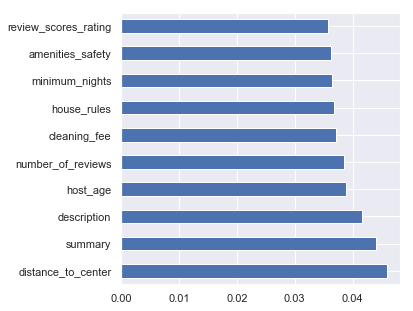

In [127]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(X_train,y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize = (5,5))
plt.show()

In [128]:
from sklearn import metrics
pred = model.predict(X_test)
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, pred)))
mape = np.mean(np.abs((y_test - pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2),"%")
print('Accuracy:', round(100*(1 - mape), 2),"%")

Mean Absolute Error (MAE): 44.651279478173606
Mean Squared Error (MSE): 3684.7195183140993
Root Mean Squared Error (RMSE): 60.70189056622618
Mean Absolute Percentage Error (MAPE): 34.48 %
Accuracy: 65.52 %


In [78]:
# create training and testing vars
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7969, 57) (7969,)
(1993, 57) (1993,)


C:\Users\aleen\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



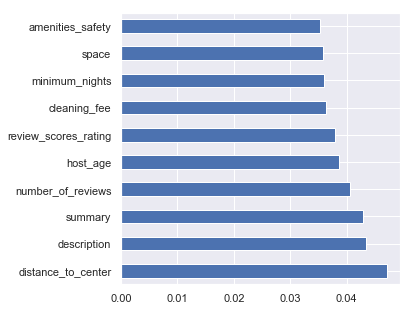

In [86]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(max_depth=2, random_state=0)
rf.fit(X_train, y_train)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', figsize = (5,5))
plt.show()

In [103]:
from sklearn import metrics
pred = rf.predict(X_test)
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, pred)))
mape = np.mean(np.abs((y_test - pred) / np.abs(y_test)))
print('Mean Absolute Percentage Error (MAPE):', round(mape * 100, 2),"%")
print('Accuracy:', round(100*(1 - mape), 2),"%")

Mean Absolute Error (MAE): 34.61247826271914
Mean Squared Error (MSE): 2068.9843199688157
Root Mean Squared Error (RMSE): 45.486089301772424
Mean Absolute Percentage Error (MAPE): 30.21 %
Accuracy: 69.79 %


In [100]:
df['price'].mean()

130.6318008432042

In [115]:
131-35

96

In [116]:
131+35

166

In [119]:
130.6318008432042/100


1.3063180084320418

In [121]:
34.61247826271914/1.3063180084320418

26.49621151917219